<a href="https://colab.research.google.com/github/mjmartey19/Telecom-Customer-Churn-Prediction-and-Analysis/blob/main/Telecom_Customer_Churn_Prediction_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Install necessary libraries if not already installed
# install.packages(c("dplyr", "ggplot2", "corrplot", "plyr"))
# Load necessary libraries
library(dplyr)      # Data manipulation
library(ggplot2)    # Data visualization
library(plyr)       # Data manipulation functions
library(corrplot)   # Correlation plots


#  Data Preparation and Cleaning

In [3]:
# Load the dataset
data <- read.csv('/kaggle/input/telecom-customers/Telecom Customers Churn.csv')


In [4]:
# View the structure and summary of the dataset to understand its contents
str(data)    # Check the structure of the dataset (data types, number of variables)
summary(data) # Summary statistics (min, max, median, mean) for numeric columns

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : chr  "7590-VHVEG" "5575-GNVDE" "3668-QPYBK" "7795-CFOCW" ...
 $ gender          : chr  "Female" "Male" "Male" "Male" ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : chr  "Yes" "No" "No" "No" ...
 $ Dependents      : chr  "No" "No" "No" "No" ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : chr  "No" "Yes" "Yes" "No" ...
 $ MultipleLines   : chr  "No phone service" "No" "No" "No phone service" ...
 $ InternetService : chr  "DSL" "DSL" "DSL" "DSL" ...
 $ OnlineSecurity  : chr  "No" "Yes" "Yes" "Yes" ...
 $ OnlineBackup    : chr  "Yes" "No" "Yes" "No" ...
 $ DeviceProtection: chr  "No" "Yes" "No" "Yes" ...
 $ TechSupport     : chr  "No" "No" "No" "Yes" ...
 $ StreamingTV     : chr  "No" "No" "No" "No" ...
 $ StreamingMovies : chr  "No" "No" "No" "No" ...
 $ Contract        : chr  "Month-to-month" "One year" "Month-to-month" "One year" ...
 $ PaperlessBilling: chr  "Yes"

  customerID           gender          SeniorCitizen      Partner         
 Length:7043        Length:7043        Min.   :0.0000   Length:7043       
 Class :character   Class :character   1st Qu.:0.0000   Class :character  
 Mode  :character   Mode  :character   Median :0.0000   Mode  :character  
                                       Mean   :0.1621                     
                                       3rd Qu.:0.0000                     
                                       Max.   :1.0000                     
                                                                          
  Dependents            tenure      PhoneService       MultipleLines     
 Length:7043        Min.   : 0.00   Length:7043        Length:7043       
 Class :character   1st Qu.: 9.00   Class :character   Class :character  
 Mode  :character   Median :29.00   Mode  :character   Mode  :character  
                    Mean   :32.37                                        
                    3rd Qu.:55

In [ ]:
# Check for missing values in the dataset
# First method: Direct sum of NA values in the dataset (doesn't reveal much detail)
colSums(is.na(data))

customerID           gender    SeniorCitizen          Partner 
               0                0                0                0 
      Dependents           tenure     PhoneService    MultipleLines 
               0                0                0                0 
 InternetService   OnlineSecurity     OnlineBackup DeviceProtection 
               0                0                0                0 
     TechSupport      StreamingTV  StreamingMovies         Contract 
               0                0                0                0 
PaperlessBilling    PaymentMethod   MonthlyCharges     TotalCharges 
               0                0                0               11 
           Churn 
               0

In [ ]:
# Second method: Apply across columns to get the number of missing values per column
sapply(data, function(x) sum(is.na(x)))

customerID           gender    SeniorCitizen          Partner 
               0                0                0                0 
      Dependents           tenure     PhoneService    MultipleLines 
               0                0                0                0 
 InternetService   OnlineSecurity     OnlineBackup DeviceProtection 
               0                0                0                0 
     TechSupport      StreamingTV  StreamingMovies         Contract 
               0                0                0                0 
PaperlessBilling    PaymentMethod   MonthlyCharges     TotalCharges 
               0                0                0               11 
           Churn 
               0

In [ ]:
# Remove rows with missing values (complete cases)
data <- data[complete.cases(data), ]  # Filters out rows with NA values

# Recode specific columns where "No internet service" should be treated as "No"
# Column indices 10 to 15 are recoded
cols_recode1 <- c(10:15)
for(i in 1:ncol(data[,cols_recode1])) {
  data[,cols_recode1][,i] <- as.factor(mapvalues(data[,cols_recode1][,i],
                                                 from =c("No internet service"),
                                                 to=c("No")))  # Replace "No internet service" with "No"
}

# Recode "No phone service" in MultipleLines as "No" (treat customers with no phone service similarly to "No")
data$MultipleLines <- as.factor(mapvalues(data$MultipleLines,
                                           from=c("No phone service"),
                                           to=c("No")))

In [ ]:
# Check minimum and maximum tenure values
min(data$tenure)
max(data$tenure)

[1] 1

[1] 72

In [ ]:

# Group customers into tenure categories for more meaningful analysis
group_tenure <- function(tenure){
  if (tenure >= 0 & tenure <= 12){
    return('0-12 Month')
  }else if(tenure > 12 & tenure <= 24){
    return('12-24 Month')
  }else if (tenure > 24 & tenure <= 48){
    return('24-48 Month')
  }else if (tenure > 48 & tenure <= 60){
    return('48-60 Month')
  }else if (tenure > 60){
    return('> 60 Month')
  }
}

# Apply tenure grouping function to the `tenure` column
data$tenure_group <- sapply(data$tenure, group_tenure)

# Convert `tenure_group` to a factor for proper analysis and plotting
data$tenure_group <- as.factor(data$tenure_group)

# Recode the SeniorCitizen column (0 as "No", 1 as "Yes")
data$SeniorCitizen <- as.factor(mapvalues(data$SeniorCitizen,
                                           from=c("0","1"),
                                           to=c("No", "Yes")))

# Drop unnecessary columns
# `customerID`: Unique identifier, irrelevant for analysis
# `tenure`: Replaced by the `tenure_group`, so no longer needed
data$customerID <- NULL
data$tenure <- NULL

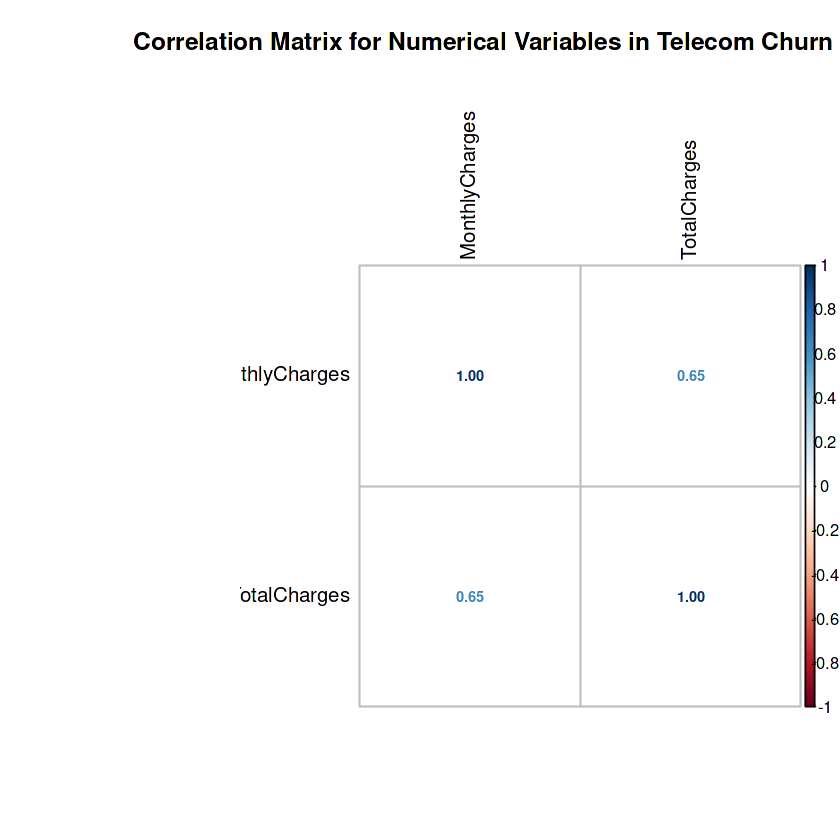

In [ ]:
# Load necessary libraries
if (!require("corrplot")) install.packages("corrplot", dependencies = TRUE)
library(corrplot)

# Identify numeric variables
numeric_vars <- sapply(data, is.numeric)

# Compute the correlation matrix for numeric variables
corr_matrix <- cor(data[, numeric_vars], use = "complete.obs")

# Plot the correlation matrix
corrplot(
  corr_matrix,
  method = "number",                # Display correlation values as numbers
  title = "\n\nCorrelation Matrix for Numerical Variables in Telecom Churn chunkset",
  mar = c(0, 10, 1, 0),              # Adjust margins to fit title
  tl.col = "black",                 # Text label color
  number.cex = 0.7                  # Number size
)


# Exploratory Data Analysis

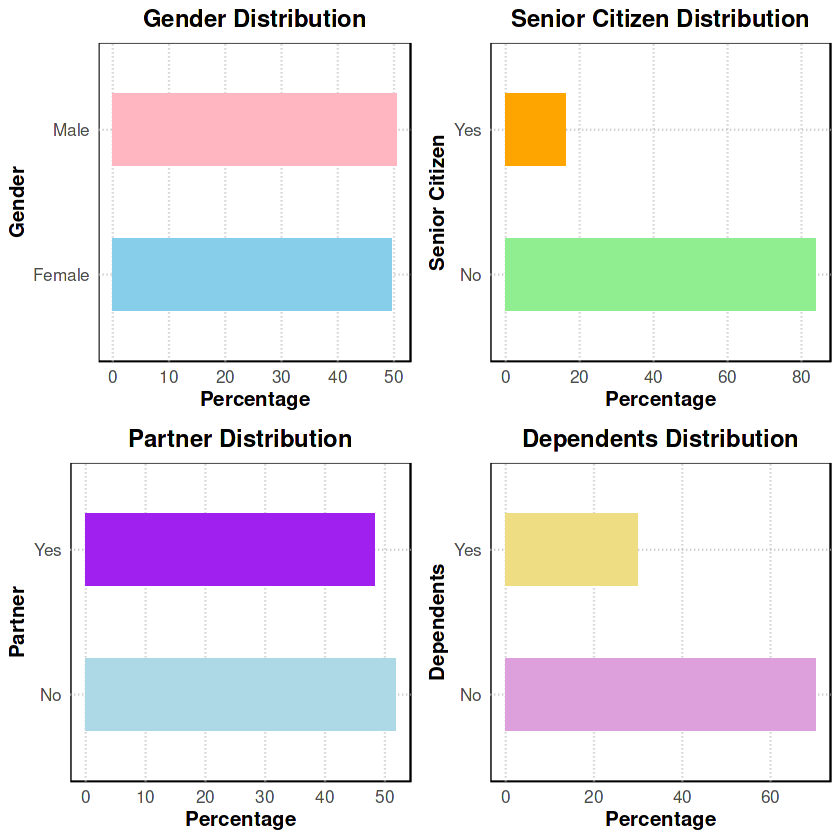

In [ ]:
# Define a custom theme for consistency
custom_theme <- theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "gray", linetype = "dotted"),
    panel.background = element_rect(fill = "white"),
    legend.position = "none"
  )

# Gender Distribution
p1 <- ggplot(data, aes(x=gender, fill=gender)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Gender Distribution") + xlab("Gender") + ylab("Percentage") +
  scale_fill_manual(values = c("skyblue", "lightpink")) +
  coord_flip() + custom_theme

# Senior Citizen Distribution
p2 <- ggplot(data, aes(x=SeniorCitizen, fill=SeniorCitizen)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Senior Citizen Distribution") + xlab("Senior Citizen") + ylab("Percentage") +
  scale_fill_manual(values = c("lightgreen", "orange")) +
  coord_flip() + custom_theme

# Partner Distribution
p3 <- ggplot(data, aes(x=Partner, fill=Partner)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Partner Distribution") + xlab("Partner") + ylab("Percentage") +
  scale_fill_manual(values = c("lightblue", "purple")) +
  coord_flip() + custom_theme

# Dependents Distribution
p4 <- ggplot(data, aes(x=Dependents, fill=Dependents)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Dependents Distribution") + xlab("Dependents") + ylab("Percentage") +
  scale_fill_manual(values = c("plum", "lightgoldenrod")) +
  coord_flip() + custom_theme

# Arrange plots in a grid
grid.arrange(p1, p2, p3, p4, ncol = 2)


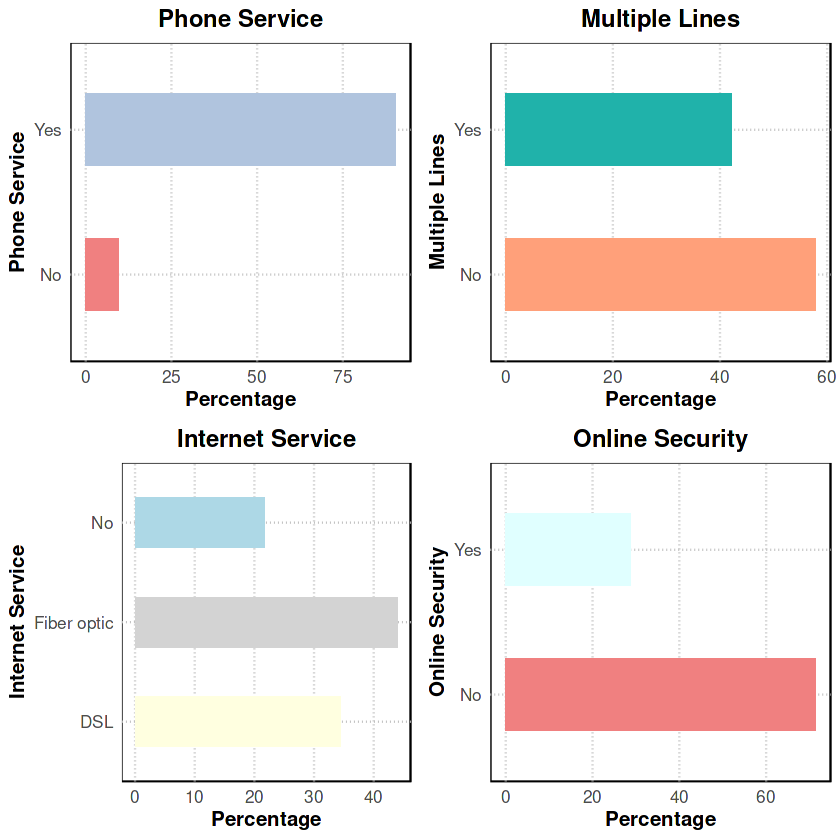

In [ ]:
# Phone Service Distribution
p5 <- ggplot(data, aes(x=PhoneService, fill=PhoneService)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Phone Service") + xlab("Phone Service") + ylab("Percentage") +
  scale_fill_manual(values = c("lightcoral", "lightsteelblue")) +
  coord_flip() + custom_theme

# Multiple Lines Distribution
p6 <- ggplot(data, aes(x=MultipleLines, fill=MultipleLines)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Multiple Lines") + xlab("Multiple Lines") + ylab("Percentage") +
  scale_fill_manual(values = c("lightsalmon", "lightseagreen")) +
  coord_flip() + custom_theme

# Internet Service Distribution
p7 <- ggplot(data, aes(x=InternetService, fill=InternetService)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Internet Service") + xlab("Internet Service") + ylab("Percentage") +
  scale_fill_manual(values = c("lightyellow", "lightgray", "lightblue")) +
  coord_flip() + custom_theme

# Online Security Distribution
p8 <- ggplot(data, aes(x=OnlineSecurity, fill=OnlineSecurity)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Online Security") + xlab("Online Security") + ylab("Percentage") +
  scale_fill_manual(values = c("lightcoral", "lightcyan")) +
  coord_flip() + custom_theme

# Arrange plots in a grid with custom theme
grid.arrange(p5, p6, p7, p8, ncol = 2)


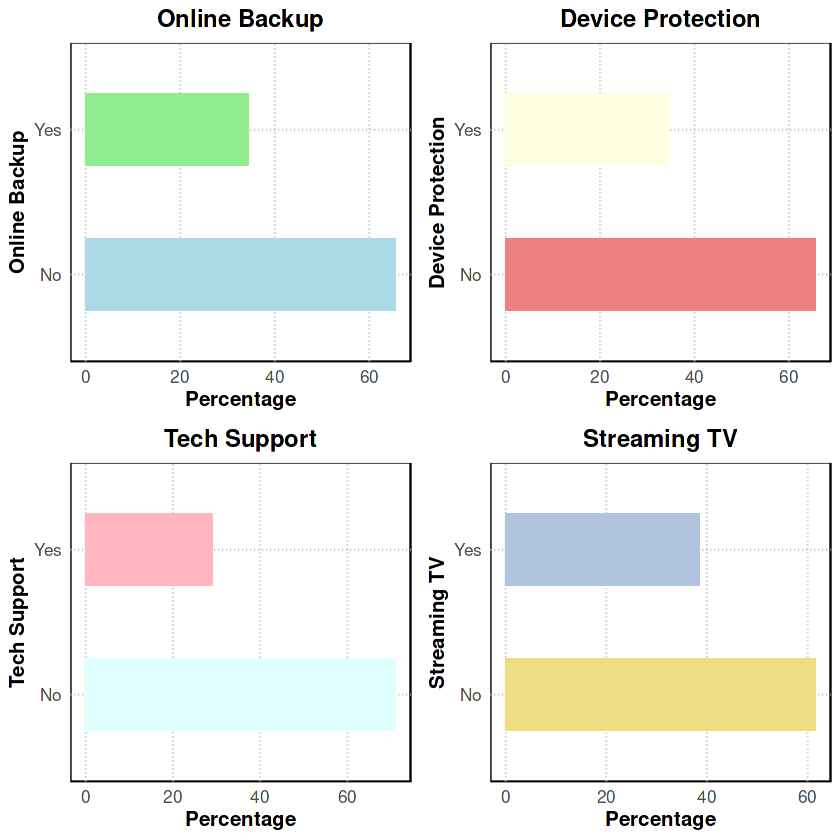

In [ ]:
# Online Backup Distribution
p9 <- ggplot(data, aes(x=OnlineBackup, fill=OnlineBackup)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Online Backup") + xlab("Online Backup") + ylab("Percentage") +
  scale_fill_manual(values = c("lightblue", "lightgreen")) +
  coord_flip() + custom_theme

# Device Protection Distribution
p10 <- ggplot(data, aes(x=DeviceProtection, fill=DeviceProtection)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Device Protection") + xlab("Device Protection") + ylab("Percentage") +
  scale_fill_manual(values = c("lightcoral", "lightyellow")) +
  coord_flip() + custom_theme

# Tech Support Distribution
p11 <- ggplot(data, aes(x=TechSupport, fill=TechSupport)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Tech Support") + xlab("Tech Support") + ylab("Percentage") +
  scale_fill_manual(values = c("lightcyan", "lightpink")) +
  coord_flip() + custom_theme

# Streaming TV Distribution
p12 <- ggplot(data, aes(x=StreamingTV, fill=StreamingTV)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Streaming TV") + xlab("Streaming TV") + ylab("Percentage") +
  scale_fill_manual(values = c("lightgoldenrod", "lightsteelblue")) +
  coord_flip() + custom_theme

# Arrange plots in a grid with custom theme
grid.arrange(p9, p10, p11, p12, ncol = 2)


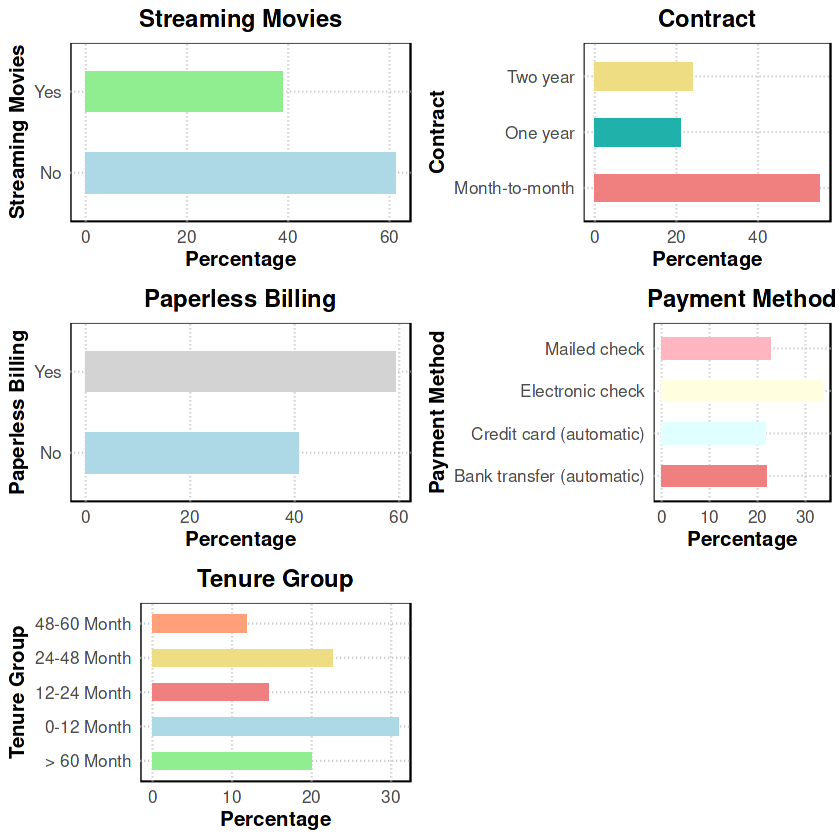

In [ ]:
# Streaming Movies Distribution
p13 <- ggplot(data, aes(x=StreamingMovies, fill=StreamingMovies)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Streaming Movies") + xlab("Streaming Movies") + ylab("Percentage") +
  scale_fill_manual(values = c("lightblue", "lightgreen")) +
  coord_flip() + custom_theme

# Contract Distribution
p14 <- ggplot(data, aes(x=Contract, fill=Contract)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Contract") + xlab("Contract") + ylab("Percentage") +
  scale_fill_manual(values = c("lightcoral", "lightseagreen", "lightgoldenrod")) +
  coord_flip() + custom_theme

# Paperless Billing Distribution
p15 <- ggplot(data, aes(x=PaperlessBilling, fill=PaperlessBilling)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Paperless Billing") + xlab("Paperless Billing") + ylab("Percentage") +
  scale_fill_manual(values = c("lightblue", "lightgray")) +
  coord_flip() + custom_theme

# Payment Method Distribution
p16 <- ggplot(data, aes(x=PaymentMethod, fill=PaymentMethod)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Payment Method") + xlab("Payment Method") + ylab("Percentage") +
  scale_fill_manual(values = c("lightcoral", "lightcyan", "lightyellow", "lightpink")) +
  coord_flip() + custom_theme

# Tenure Group Distribution
p17 <- ggplot(data, aes(x=tenure_group, fill=tenure_group)) +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) +
  ggtitle("Tenure Group") + xlab("Tenure Group") + ylab("Percentage") +
  scale_fill_manual(values = c("lightgreen", "lightblue", "lightcoral", "lightgoldenrod", "lightsalmon")) +
  coord_flip() + custom_theme

# Arrange plots in a grid with custom theme
grid.arrange(p13, p14, p15, p16, p17, ncol = 2)


# **Inferential Statistics and Predictive Modeling**
split the data into training and testing sets:

In [ ]:
intrain<- createDataPartition(data$Churn,p=0.7,list=FALSE)
set.seed(2017)
training<- data[intrain,]
testing<- data[-intrain,]

dim(training); dim(testing)

[1] 4924   20

[1] 2108   20

In [ ]:
# Ensure the response variable Churn is correctly formatted
training$Churn <- as.character(training$Churn)
training$Churn[training$Churn == "No"] <- "0"
training$Churn[training$Churn == "Yes"] <- "1"
training$Churn <- as.factor(training$Churn)

testing$Churn <- as.character(testing$Churn)
testing$Churn[testing$Churn == "No"] <- "0"
testing$Churn[testing$Churn == "Yes"] <- "1"
testing$Churn <- as.factor(testing$Churn)


In [ ]:
# Fit the Logistic Regression Model
LogModel <- glm(Churn ~ ., family=binomial(link="logit"), data=training)
print(summary(LogModel))


Call:
glm(formula = Churn ~ ., family = binomial(link = "logit"), data = training)

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -1.427e-01  1.007e+00  -0.142 0.887306    
genderMale                           -6.121e-02  7.757e-02  -0.789 0.430104    
SeniorCitizenYes                      2.227e-01  1.007e-01   2.212 0.026969 *  
PartnerYes                            1.567e-02  9.234e-02   0.170 0.865222    
DependentsYes                        -1.367e-01  1.063e-01  -1.286 0.198512    
PhoneServiceYes                       8.537e-01  7.702e-01   1.108 0.267650    
MultipleLinesYes                      6.327e-01  2.117e-01   2.988 0.002806 ** 
InternetServiceFiber optic            2.559e+00  9.458e-01   2.705 0.006823 ** 
InternetServiceNo                    -2.423e+00  9.590e-01  -2.526 0.011526 *  
OnlineSecurityYes                     3.846e-02  2.127e-01   0.181 0.856546    
OnlineBackupYes      

In [ ]:
# Perform ANOVA to test the significance of the model
anova(LogModel, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,4923,5702.760,NA
gender,1,1.370656e+00,4922,5701.389,2.416992e-01
SeniorCitizen,1,9.976086e+01,4921,5601.628,1.719549e-23
Partner,1,1.048258e+02,4920,5496.802,1.333572e-24
Dependents,1,3.384608e+01,4919,5462.956,5.964922e-09
PhoneService,1,1.286062e+00,4918,5461.670,2.567750e-01
MultipleLines,1,5.913712e+00,4917,5455.757,1.502348e-02
InternetService,2,5.136131e+02,4915,4942.143,2.953440e-112
OnlineSecurity,1,1.547419e+02,4914,4787.401,1.594359e-35


In [ ]:
# Predict using the Logistic Regression Model
fitted.results <- predict(LogModel, newdata=testing, type='response')
fitted.results <- ifelse(fitted.results > 0.5, "1", "0")

In [ ]:
# Calculate and print the classification error and accuracy
misClasificError <- mean(fitted.results != testing$Churn)
print(paste('Logistic Regression Accuracy:', 1 - misClasificError))

# Calculate and print odds ratios and their confidence intervals
odds_ratios <- exp(cbind(OR = coef(LogModel), confint(LogModel)))
print(odds_ratios)

[1] "Logistic Regression Accuracy: 0.802656546489564"


Waiting for profiling to be done...



                                              OR      2.5 %     97.5 %
(Intercept)                           0.86701733 0.12053931  6.2497303
genderMale                            0.94062933 0.80791632  1.0951002
SeniorCitizenYes                      1.24949742 1.02546683  1.5219351
PartnerYes                            1.01579613 0.84773114  1.2175711
DependentsYes                         0.87225767 0.70771485  1.0736836
PhoneServiceYes                       2.34840824 0.51944947 10.6439798
MultipleLinesYes                      1.88271294 1.24400137  2.8535938
InternetServiceFiber optic           12.91960113 2.02999158 82.8197923
InternetServiceNo                     0.08866783 0.01350128  0.5801605
OnlineSecurityYes                     1.03920711 0.68472456  1.5768981
OnlineBackupYes                       1.21340494 0.80651864  1.8266428
DeviceProtectionYes                   1.43210795 0.95216546  2.1557018
TechSupportYes                        1.11339222 0.73163720  1.6944875
Stream

In [ ]:
# Convert predictions to factor for confusion matrix
fitted.results <- as.factor(fitted.results)
testing$Churn <- as.factor(testing$Churn)

# Create confusion matrix
conf_matrix <- confusionMatrix(fitted.results, testing$Churn)
print(conf_matrix)


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1413  281
         1  135  279
                                         
               Accuracy : 0.8027         
                 95% CI : (0.785, 0.8195)
    No Information Rate : 0.7343         
    P-Value [Acc > NIR] : 1.478e-13      
                                         
                  Kappa : 0.4483         
                                         
 Mcnemar's Test P-Value : 1.167e-12      
                                         
            Sensitivity : 0.9128         
            Specificity : 0.4982         
         Pos Pred Value : 0.8341         
         Neg Pred Value : 0.6739         
             Prevalence : 0.7343         
         Detection Rate : 0.6703         
   Detection Prevalence : 0.8036         
      Balanced Accuracy : 0.7055         
                                         
       'Positive' Class : 0              
                                         


In [ ]:
# Calculate Accuracy
accuracy <- conf_matrix$overall['Accuracy']
print(paste('Accuracy:', accuracy))

# Calculate Precision, Recall, and F1-Score
precision <- conf_matrix$byClass['Pos Pred Value']
recall <- conf_matrix$byClass['Sensitivity']
f1_score <- 2 * (precision * recall) / (precision + recall)

print(paste('Precision:', precision))
print(paste('Recall:', recall))
print(paste('F1-Score:', f1_score))

[1] "Accuracy: 0.802656546489564"
[1] "Precision: 0.834120425029516"
[1] "Recall: 0.912790697674419"
[1] "F1-Score: 0.871684145589142"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.705502491694352"


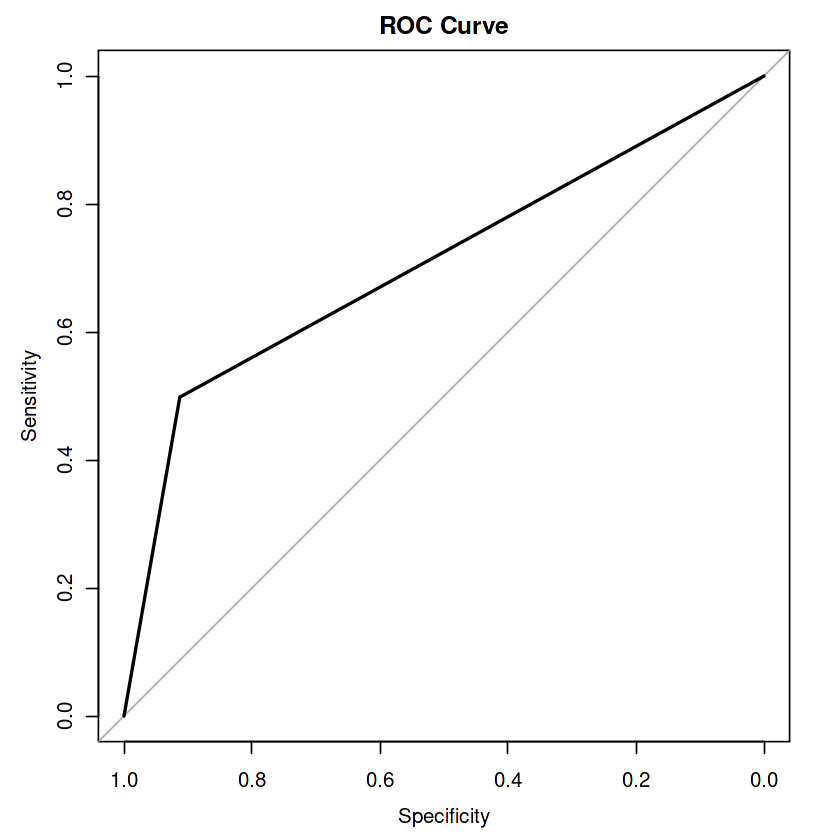

In [ ]:
# Load necessary libraries
library(pROC)   # For ROC and AUC

# ROC curve and AUC
roc_curve <- roc(testing$Churn, as.numeric(fitted.results))
auc_value <- auc(roc_curve)

# Plot ROC curve
plot(roc_curve, main = "ROC Curve")
print(paste('AUC:', auc_value))